In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
#algorithm for that shit        ,       n=null, e=eins

nn = ["0000","1111"]
ne = ["0011","1100"]
en = ["0101","1010"]
ee = ["0110","1001"]

def idk(new: list, a: list, b:list, c:list):
    for i in a:
        for j in b:
            for k in c:
                new.append(i+j+k)

#noisefree gates
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [3]:
def code():                                     #intialize |00> state
    qr = QuantumRegister(15,"q")
    cbits = ClassicalRegister(24,"c")             #12(Auslesen am Ende) + 7(Preselection) + 5(Stabilizers) = 24 insgesamt
    qc = QuantumCircuit(qr, cbits)

    q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(7)
    qc.h(11)
    qc.h(12)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)


    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)

    qc.cx(7,4)
    qc.cx(7,5)
    qc.cx(7,6)

    qc.cx(11,8)
    qc.cx(11,9)
    qc.cx(11,10)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)

    qc.h(12)
    qc.measure(12,0)
    qc.measure(13,1)
    qc.measure(14,2)

    qc.reset(12)
    qc.reset(13)
    qc.reset(14)
    ####################################################
    for i in range(8):
        qc.cx(i,i+4)
    ####################################################
    qc.h(12)

    qc.cx(12,4)
    qc.cx(7,13)
    qc.cx(12,7)
    qc.cx(4,13)
    qc.cx(12,5)
    qc.cx(6,13)
    qc.cx(12,6)
    qc.cx(5,13)

    qc.h(12)
    qc.measure(12,3)
    qc.measure(13,4)

    qc.reset(12)
    qc.reset(13)
    
    ####################################################
    qc.h(12)

    qc.cx(12,13)
    qc.cx(8,13)
    qc.cx(10,12)
    qc.cx(9,12)
    qc.cx(11,13)
    qc.cx(12,13)

    qc.h(12)

    qc.measure(12,5)
    qc.measure(13,6)

    qc.reset(12)
    qc.reset(13)

    q[5],q[7] = q[7],q[5]
    q[6],q[7] = q[7],q[6]

    q[9],q[10] = q[10],q[9]
    q[10],q[11] = q[11],q[10]
    
    return qc, q

def X_L(qc: QuantumCircuit, q: list, pos: int):
    qc.x(q[3])
    qc.x(q[10])
    if pos == 0:
        qc.x(q[0])
        qc.x(q[11])
    elif pos == 1:
        qc.x(q[1])
        qc.x(q[9])

def Z_L(qc: QuantumCircuit, q: list, pos: int):
    qc.z(q[0])
    qc.z(q[9])
    if pos == 0:
        qc.z(q[3])
        qc.z(q[11])
    elif pos == 1:
        qc.z(q[1])
        qc.z(q[10])

def CNOT_L(qc: QuantumCircuit, q: list, control = 0):
    for i in range(4):
        q[i], q[i+8] = q[i+8], q[i]
    
    if control == 0:
        q[0], q[1] = q[1], q[0]
        q[4], q[5] = q[5], q[4]
        q[8], q[9] = q[9], q[8]
    else:
        q[0], q[2] = q[2], q[0]
        q[4], q[6] = q[6], q[4]
        q[8], q[10] = q[10], q[8]

def H_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    if pos != 2:
        qc.reset(anc)
        
        Z_L(qc, q, pos=pos)

        if pos == 0:                  #hier zu Z_L
            qc.cx(q[0], anc)
            qc.cx(q[3], anc)
            qc.cx(q[9], anc)
            qc.cx(q[11], anc)
        elif pos == 1:
            qc.cx(q[0], anc)
            qc.cx(q[1], anc)
            qc.cx(q[9], anc)
            qc.cx(q[10], anc)
        qc.h(anc)
        if pos == 0:
            qc.cx(anc, q[0])
            qc.cx(anc, q[3])
            qc.cx(anc, q[10])
            qc.cx(anc, q[11])
        elif pos == 1:
            qc.cx(anc, q[1])
            qc.cx(anc, q[3])
            qc.cx(anc, q[9])
            qc.cx(anc, q[10])
        qc.h(anc)
        qc.measure(anc, 7)
        if pos == 0:                        #hier zu X_L
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])

                qc.x(q[0])
                qc.x(q[3])
                qc.x(q[10])
                qc.x(q[11])
            #q[9], q[10] = q[10], q[9]
        elif pos == 1:
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

                qc.x(q[1])
                qc.x(q[3])
                qc.x(q[9])
                qc.x(q[10])
            #q[0], q[3] = q[3], q[0]
    if pos == 2:
        for i in range(12):
            qc.h(q[i])
        q[0], q[3] = q[3], q[0]
        q[5], q[6] = q[6], q[5]
        q[9], q[10] = q[10], q[9]

def CZ_L(qc: QuantumCircuit, q:list):
    H_L(qc, q, 0)
    CNOT_L(qc, q, 1)
    H_L(qc, q, 0)

def S_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.h(anc)
    qc.s(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[3])
            qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[1])
            qc.z(q[10])

def adj_S_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.h(anc)
    qc.sdg(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[3])
            qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[1])
            qc.z(q[10])

def T_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.h(anc)
    qc.t(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.s(anc)
            qc.cx(q[0], anc)
            qc.cx(q[3], anc)
            qc.cx(q[9], anc)
            qc.cx(q[11], anc)
            qc.measure(anc,7)
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.s(anc)
            qc.cx(q[0], anc)
            qc.cx(q[1], anc)
            qc.cx(q[9], anc)
            qc.cx(q[10], anc)
            qc.measure(anc,7)
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

def adj_T_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    qc.h(anc)
    qc.tdg(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,7)
    if pos == 0:
        with qc.if_test((7,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.sdg(anc)
            qc.cx(q[0], anc)
            qc.cx(q[3], anc)
            qc.cx(q[9], anc)
            qc.cx(q[11], anc)
            qc.measure(anc,7)
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])
    elif pos == 1:
        with qc.if_test((7,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.sdg(anc)
            qc.cx(q[0], anc)
            qc.cx(q[1], anc)
            qc.cx(q[9], anc)
            qc.cx(q[10], anc)
            qc.measure(anc,7)
            with qc.if_test((7,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

def CS_L(qc: QuantumCircuit, q: list):
    T_L(qc, q, 0)
    T_L(qc, q, 1)
    CNOT_L(qc, q, 0)
    adj_T_L(qc, q, 1)
    CNOT_L(qc, q, 0)

def readout(qc: QuantumCircuit, shots: int, q: list, noise = 0):
    for i in range(12):
        qc.measure(q[i],23-i)

    # p = noise
    # p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    # p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg"])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    depolarizing_prob = noise
    dep_error = depolarizing_error(depolarizing_prob, 1)
    dep_error_2q = depolarizing_error(depolarizing_prob, 2)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","sdg"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model = noise_model)
    result = job.result()
    counts = result.get_counts()
    
    nn = ["0000","1111"]
    ne = ["0011","1100"]
    en = ["0101","1010"]
    ee = ["0110","1001"]
    zerozero = []
    zeroone = []
    onezero = []
    oneone = []

    for i in range(1):
        idk(zerozero, nn, nn, nn)
        idk(zerozero, ne, en, ee)
        idk(zerozero, en, ee, ne)
        idk(zerozero, ee, ne, en)
        idk(zeroone, en, nn, ee)
        idk(zeroone, ee, en, nn)
        idk(zeroone, nn, ee, en)
        idk(zeroone, ne, ne, ne)
        idk(onezero, ee, nn, ne)
        idk(onezero, en, en, en)
        idk(onezero, ne, ee, nn)
        idk(onezero, nn, ne, ee)
        idk(oneone, ne, nn, en)
        idk(oneone, nn, en, ne)
        idk(oneone, ee, ee, ee)
        idk(oneone, en, ne, nn)

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[17:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]
    
    for i in range(len(bits)):
        for j in zerozero:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in zeroone:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            for j in onezero:
                if j == bits[i]:
                    bits[i] = 2
                    break
        if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
            for j in oneone:
                if j == bits[i]:
                    bits[i] = 3
                    break
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
            bits[i] = "post"

    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]

    nullnull = (nullnull/shots)*100
    nulleins = (nulleins/shots)*100
    einsnull = (einsnull/shots)*100
    einseins = (einseins/shots)*100
    preselected = (preselected/shots)*100
    post = (post/shots)*100

    return [preselected, post, nullnull, nulleins, einsnull, einseins]

def readout_anders_lol(qc: QuantumCircuit, shots: int, q: list, noise = 0):      #einfacher ablesblar, was genau ich messe, aber macht das selbe
    for i in range(12):
        qc.measure(q[i],18-i)
    
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    nn = ["0000","1111"]
    ne = ["0011","1100"]
    en = ["0101","1010"]
    ee = ["0110","1001"]

    zerozero = ["000","123","231","312"]
    zeroone = ["203","320","032","111"]
    onezero = ["301","222","130","013"]
    oneone = ["102","021","333","210"]

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[12:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    C4_1 = [i[:4] for i in bits]
    C4_2 = [i[4:8] for i in bits]
    C4_3 = [i[8:12] for i in bits]

    test = []

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]

    for i in range(len(C4_1)):
        for j in nn:
            if j == C4_1[i]:
                C4_1[i] = "0"
                break
        if C4_1[i] != 0:
            for j in ne:
                if j == C4_1[i]:
                    C4_1[i] = "1"
                    break
        if C4_1[i] != 1 and C4_1[i] != 0:
            for j in en:
                if j == C4_1[i]:
                    C4_1[i] = "2"
                    break
        if C4_1[i] != 2 and C4_1[i] != 1 and C4_1[i] != 0:
            for j in ee:
                if j == C4_1[i]:
                    C4_1[i] = "3"
                    break
        if C4_1[i] != "0" and C4_1[i] != "1" and C4_1[i] != "2" and C4_1[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_2)):
        for j in nn:
            if j == C4_2[i]:
                C4_2[i] = "0"
                break
        if C4_2[i] != 0:
            for j in ne:
                if j == C4_2[i]:
                    C4_2[i] = "1"
                    break
        if C4_2[i] != 1 and C4_2[i] != 0:
            for j in en:
                if j == C4_2[i]:
                    C4_2[i] = "2"
                    break
        if C4_2[i] != 2 and C4_2[i] != 1 and C4_2[i] != 0:
            for j in ee:
                if j == C4_2[i]:
                    C4_2[i] = "3"
                    break
        if C4_2[i] != "0" and C4_2[i] != "1" and C4_2[i] != "2" and C4_2[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_3)):
        for j in nn:
            if j == C4_3[i]:
                C4_3[i] = "0"
                break
        if C4_3[i] != 0:
            for j in ne:
                if j == C4_3[i]:
                    C4_3[i] = "1"
                    break
        if C4_3[i] != 1 and C4_3[i] != 0:
            for j in en:
                if j == C4_3[i]:
                    C4_3[i] = "2"
                    break
        if C4_3[i] != 2 and C4_3[i] != 1 and C4_3[i] != 0:
            for j in ee:
                if j == C4_3[i]:
                    C4_3[i] = "3"
                    break
        if C4_3[i] != "0" and C4_3[i] != "1" and C4_3[i] != "2" and C4_3[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_1)):
        ehm = C4_1[i] + C4_2[i] + C4_3[i]
        test.append(ehm)

    print(test)

    for i in range(len(test)):
        for j in zerozero:
            if j == test[i]:
                bits[i] = 0
        if bits[i] != 0:
            for j in zeroone:
                if j == test[i]:
                    bits[i] = 1
        if bits[i] != 0 and bits[i] != 1:
            for j in onezero:
                if j == test[i]:
                    bits[i] = 2
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2:
            for j in oneone:
                if j == test[i]:
                    bits[i] = 3
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3:
            bits[i] = "post"
    
    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]

    nullnull = (nullnull/shots)*100
    nulleins = (nulleins/shots)*100
    einsnull = (einsnull/shots)*100
    einseins = (einseins/shots)*100
    preselected = (preselected/shots)*100
    post = (post/shots)*100

    return [preselected, post, nullnull, nulleins, einsnull, einseins]

def qec(qc: QuantumCircuit, q: list):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    #####################Bitflip Error Stabilizer messen########################################
    for k in range(1):

        #S2 Stabilizers
        for i in range(4):
            qc.cx(q[i], anc)
        qc.measure(anc, 19)
        qc.reset(anc)

        #S4 Stabilizer
        for i in range(4):
            qc.cx(q[i+4], anc)
        qc.measure(anc, 20)
        qc.reset(anc)

        #S6 Stabilizer
        for i in range(4):
            qc.cx(q[i+8], anc)
        qc.measure(anc, 21)
        qc.reset(anc)

        #S9 Stabilizer
        qc.cx(q[0],anc)
        qc.cx(q[2],anc)
        qc.cx(q[6],anc)
        qc.cx(q[7],anc)
        qc.cx(q[8],anc)
        qc.cx(q[11],anc)
        qc.measure(anc, 22)
        qc.reset(anc)

        #S10 Stabilizer
        qc.cx(q[0],anc)
        qc.cx(q[3],anc)
        qc.cx(q[4],anc)
        qc.cx(q[6],anc)
        qc.cx(q[10],anc)
        qc.cx(q[11],anc)
        qc.measure(anc, 23)
        qc.reset(anc)

        with qc.if_test((19,1)):            #X0
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[0])

        with qc.if_test((19,1)):            #X1
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[1])

        with qc.if_test((19,1)):            #X2
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[2])

        with qc.if_test((19,1)):            #X3
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[3])

        with qc.if_test((20,1)):            #X4
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[4])

        with qc.if_test((20,1)):            #X5
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[5])

        with qc.if_test((20,1)):            #X6
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[6])

        with qc.if_test((20,1)):            #X7
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[7])

        with qc.if_test((21,1)):            #X8
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[8])
        
        with qc.if_test((21,1)):            #X9
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[9])
        
        with qc.if_test((21,1)):            #X10
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[10])

        with qc.if_test((21,1)):            #X11
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[11])

    ###################Phaseflip Error Stabilizers############################
    for k in range(1):
        #S1 Stabilizers
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i])
        qc.h(anc)
        qc.measure(anc, 19)
        qc.reset(anc)

        #S3 Stabilizer
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i+4])
        qc.h(anc)
        qc.measure(anc, 20)
        qc.reset(anc)

        #S5 Stabilizer
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i+8])
        qc.h(anc)
        qc.measure(anc, 21)
        qc.reset(anc)

        #S7 Stabilizer
        qc.h(anc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[1])
        qc.cx(anc, q[5])
        qc.cx(anc, q[7])
        qc.cx(anc, q[8])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.measure(anc, 22)
        qc.reset(anc)

        #S8 Stabilizer
        qc.h(anc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[3])
        qc.cx(anc, q[4])
        qc.cx(anc, q[5])
        qc.cx(anc, q[9])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.measure(anc, 23)
        qc.reset(anc)

        with qc.if_test((19,1)):            #Z0
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.z(q[0])

        with qc.if_test((19,1)):            #Z1
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.z(q[1])

        with qc.if_test((19,1)):            #Z2
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.z(q[2])

        with qc.if_test((19,1)):            #Z3
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.z(q[3])

        with qc.if_test((20,1)):            #Z4
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.z(q[4])

        with qc.if_test((20,1)):            #Z5
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.z(q[5])

        with qc.if_test((20,1)):            #Z6
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.z(q[6])

        with qc.if_test((19,1)):            #Z7
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.z(q[7])

        with qc.if_test((21,1)):            #Z8
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.z(q[8])
        
        with qc.if_test((21,1)):            #Z9
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.z(q[9])
        
        with qc.if_test((21,1)):            #Z10
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.z(q[10])

        with qc.if_test((21,1)):            #Z11
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.z(q[11])

def qec_ideal(qc: QuantumCircuit, q:list):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    #####################Bitflip Error Stabilizer messen########################################
    for k in range(1):

        #S2 Stabilizers
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i]])
        qc.measure(anc, 19)
        qc.reset(anc)

        #S4 Stabilizer
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i+4]])
        qc.measure(anc, 20)
        qc.reset(anc)

        #S6 Stabilizer
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i+8]])
        qc.measure(anc, 21)
        qc.reset(anc)

        #S9 Stabilizer
        qc.append(cx_ideal, [anc, q[0]])
        qc.append(cx_ideal, [anc, q[2]])
        qc.append(cx_ideal, [anc, q[6]])
        qc.append(cx_ideal, [anc, q[7]])
        qc.append(cx_ideal, [anc, q[8]])
        qc.append(cx_ideal, [anc, q[11]])
        qc.measure(anc, 22)
        qc.reset(anc)

        #S10 Stabilizer
        qc.append(cx_ideal, [anc, q[0]])
        qc.append(cx_ideal, [anc, q[3]])
        qc.append(cx_ideal, [anc, q[4]])
        qc.append(cx_ideal, [anc, q[6]])
        qc.append(cx_ideal, [anc, q[10]])
        qc.append(cx_ideal, [anc, q[11]])
        qc.measure(anc, 23)
        qc.reset(anc)

        with qc.if_test((19,1)):            #X0
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.append(x_ideal, [q[0]])

        with qc.if_test((19,1)):            #X1
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.append(x_ideal, [q[1]])

        with qc.if_test((19,1)):            #X2
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.append(x_ideal, [q[2]])

        with qc.if_test((19,1)):            #X3
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.append(x_ideal, [q[3]])

        with qc.if_test((20,1)):            #X4
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.append(x_ideal, [q[4]])

        with qc.if_test((20,1)):            #X5
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.append(x_ideal, [q[5]])

        with qc.if_test((20,1)):            #X6
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.append(x_ideal, [q[6]])

        with qc.if_test((20,1)):            #X7
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.append(x_ideal, [q[7]])

        with qc.if_test((21,1)):            #X8
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.append(x_ideal, [q[8]])
        
        with qc.if_test((21,1)):            #X9
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.append(x_ideal, [q[9]])
        
        with qc.if_test((21,1)):            #X10
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.append(x_ideal, [q[10]])

        with qc.if_test((21,1)):            #X11
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.append(x_ideal, [q[11]])

    ###################Phaseflip Error Stabilizers############################
    for k in range(1):
        #S1 Stabilizers
        qc.append(h_ideal, [anc])
        for i in range(4):
            qc.append(cx_ideal, [q[i], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 19)
        qc.reset(anc)

        #S3 Stabilizer
        qc.append(h_ideal, [anc])
        for i in range(4):
            qc.append(cx_ideal, [q[i+4], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 20)
        qc.reset(anc)

        #S5 Stabilizer
        qc.append(h_ideal, [anc])
        for i in range(4):
            qc.append(cx_ideal, [q[i+8], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 21)
        qc.reset(anc)

        #S7 Stabilizer
        qc.append(h_ideal, [anc])
        qc.append(cx_ideal, [q[0], anc])
        qc.append(cx_ideal, [q[1], anc])
        qc.append(cx_ideal, [q[5], anc])
        qc.append(cx_ideal, [q[7], anc])
        qc.append(cx_ideal, [q[8], anc])
        qc.append(cx_ideal, [q[11], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 22)
        qc.reset(anc)

        #S8 Stabilizer
        qc.append(h_ideal, [anc])
        qc.append(cx_ideal, [q[0], anc])
        qc.append(cx_ideal, [q[3], anc])
        qc.append(cx_ideal, [q[4], anc])
        qc.append(cx_ideal, [q[5], anc])
        qc.append(cx_ideal, [q[9], anc])
        qc.append(cx_ideal, [q[11], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 23)
        qc.reset(anc)

        with qc.if_test((19,1)):            #Z0
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.append(z_ideal,[q[0]])

        with qc.if_test((19,1)):            #Z1
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.append(z_ideal,[q[1]])

        with qc.if_test((19,1)):            #Z2
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.append(z_ideal,[q[2]])

        with qc.if_test((19,1)):            #Z3
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.append(z_ideal,[q[3]])

        with qc.if_test((20,1)):            #Z4
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.append(z_ideal,[q[4]])

        with qc.if_test((20,1)):            #Z5
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.append(z_ideal,[q[5]])

        with qc.if_test((20,1)):            #Z6
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.append(z_ideal,[q[6]])

        with qc.if_test((19,1)):            #Z7
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.append(z_ideal,[q[7]])

        with qc.if_test((21,1)):            #Z8
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.append(z_ideal,[q[8]])
        
        with qc.if_test((21,1)):            #Z9
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.append(z_ideal,[q[9]])
        
        with qc.if_test((21,1)):            #Z10
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.append(z_ideal,[q[10]])

        with qc.if_test((21,1)):            #Z11
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.append(z_ideal,[q[11]])     

In [4]:
#iQPE first iteration           93,1

qc, q = code()

qec_ideal(qc, q)

H_L(qc, q, 0)

qec_ideal(qc, q)

X_L(qc, q, 1)

qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)
CNOT_L(qc, q, 1)
H_L(qc, q, 0)

qec_ideal(qc, q)

H_L(qc, q, 0)

qec_ideal(qc, q)

result = readout(qc, 1000, q, 0.005)

print("Preselected: ", result[0], "%")
print("Postselected: ", result[1], "%")
print("00: ", result[2], "%")
print("01: ", result[3], "%")
print("10: ", result[4], "%")
print("11: ", result[5], "%")

print("Succesrate: ", (result[5]+ result[4])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  15.5 %
Postselected:  1.2 %
00:  0.0 %
01:  8.5 %
10:  0.1 %
11:  74.7 %
Succesrate:  0.8979591836734694


In [265]:
#iQPE first iteration

qc, q = code()

qec_ideal(qc,q)

result = readout(qc, 5000, q, 0.01)

print("Preselected: ", result[0], "%")
print("Postselected: ", result[1], "%")
print("00: ", result[2], "%")
print("01: ", result[3], "%")
print("10: ", result[4], "%")
print("11: ", result[5], "%")

print("Succesrate: ", (result[5]+ result[4])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  27.02 %
Postselected:  0.06 %
00:  72.92 %
01:  0.0 %
10:  0.0 %
11:  0.0 %
Succesrate:  0.0


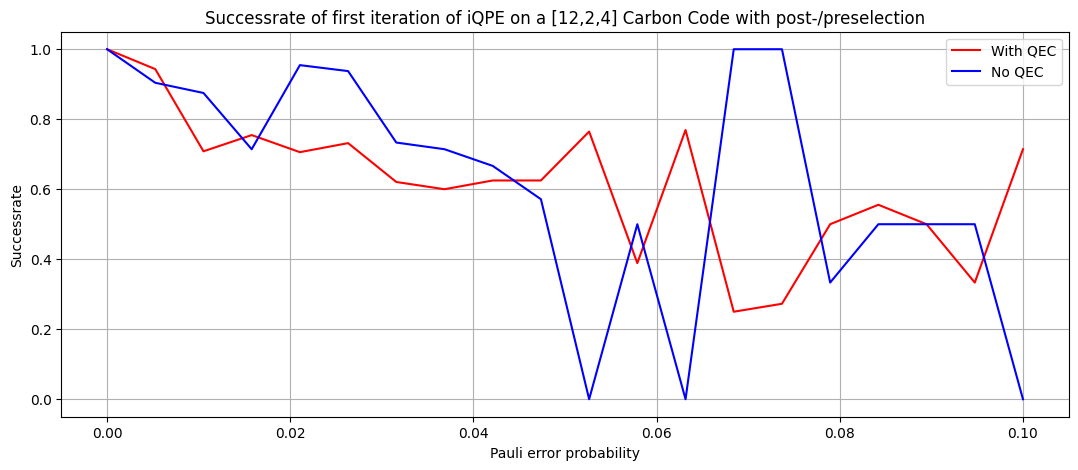

In [23]:
x = np.linspace(0,0.1,20)
y = []
y_no_QEC = []
shots = 100
pre,pre_no_QEC, post, post_no_QEC = [],[],[],[]
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc, q = code()

    X_L(qc, q, 1)

    H_L(qc, q, 0)

    CZ_L(qc, q)

    H_L(qc, q, 0)

    #CNOT_L(qc, q, 1)

    result = readout(qc, shots, q, i)

    nice, total = result[4] + result[5], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)
    
    pre_no_QEC.append(result[0]/100)
    post_no_QEC.append(result[1]/100)

    ###############################################################################################################
    qc, q = code()

    qec_ideal(qc, q)

    H_L(qc, q, 0)

    qec_ideal(qc, q)

    X_L(qc, q, 1)

    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 1)
    H_L(qc, q, 0)

    qec_ideal(qc, q)

    H_L(qc, q, 0)

    qec_ideal(qc, q)

    result = readout(qc, shots, q, i)

    nice, total = result[4] + result[5], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)
    pre.append(result[0]/100)
    post.append(result[1]/100)

data = np.array((pre,pre_no_QEC,post,post_no_QEC,x,y,y_no_QEC))
np.savetxt("Plots/text/Carbon_1st_depol_10k.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [21]:
qc, q = code()                      #92,4

qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)

X_L(qc, q, 1)
qec_ideal(qc, q)

T_L(qc, q, 0)
qec_ideal(qc, q)
T_L(qc, q, 1)
qec_ideal(qc, q)
CNOT_L(qc, q, 0)
adj_T_L(qc, q, 1)
qec_ideal(qc, q)
CNOT_L(qc, q, 0)

adj_S_L(qc, q, 0)
qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)

result = readout(qc, 1000, q, 0.005)

print("Preselected: ", result[0], "%")
print("Postselected: ", result[1], "%")
print("00: ", result[2], "%")
print("01: ", result[3], "%")
print("10: ", result[4], "%")
print("11: ", result[5], "%")

print("Succesrate: ", (result[2]+ result[3])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  16.8 %
Postselected:  0.6 %
00:  0.0 %
01:  73.4 %
10:  0.0 %
11:  9.2 %
Succesrate:  0.8886198547215496


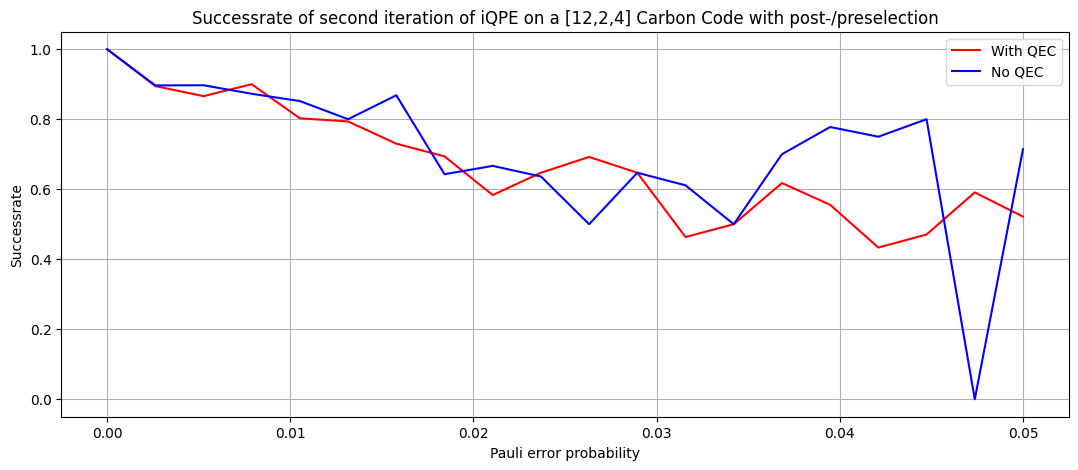

In [26]:
x = np.linspace(0,0.05,20)
y = []
y_no_QEC = []
pre,pre_no_QEC, post, post_no_QEC = [],[],[],[]
shots = 100
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc, q = code()

    H_L(qc, q, 0)

    X_L(qc, q, 1)

    CS_L(qc, q)
    adj_S_L(qc, q, 0)

    H_L(qc, q, 0)

    #CNOT_L(qc, q, 1)

    result = readout(qc, shots, q, i)

    nice, total = result[2] + result[3], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)
    pre_no_QEC.append(result[0]/100)
    post_no_QEC.append(result[1]/100)

    ###############################################################################################################

    qc, q = code()                      #92,4

    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)

    X_L(qc, q, 1)
    qec_ideal(qc, q)

    T_L(qc, q, 0)
    qec_ideal(qc, q)
    T_L(qc, q, 1)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 0)
    adj_T_L(qc, q, 1)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 0)

    adj_S_L(qc, q, 0)
    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)


    result = readout(qc, shots, q, i)

    nice, total = result[2] + result[3], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)

    pre.append(result[0]/100)
    post.append(result[1]/100)

data = np.array((pre,pre_no_QEC,post,post_no_QEC,x,y,y_no_QEC))
np.savetxt("Plots/text/Carbon_2nd_depol_10k.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of second iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()